In [1]:
import pandas.io.sql as psql
import json
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
#from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit import rdBase
from rdkit import DataStructs
#import psycopg2 as pg


import pandas as pd
import sqlalchemy as db
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from pandas import concat

from collections import OrderedDict
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split

import cheminformatics.utils.multicore as multicore
import time
import math
from multiprocessing import Pool,Queue, Process, cpu_count
import os
import sys

import chemfp
from chemfp import search

import numpy as np

import random
from numpy import median 
from itertools import combinations

from rdkit.Chem import QED 

# read core info

In [2]:
pool = pd.read_csv("../03_target_pred/Results/query_with_targets.csv",encoding='utf-8')

In [3]:
print(pool.shape)
pool.head()

(1448145, 3)


query_index                   query_smiles                  targets
0         9812   C1CCCC(N2CCN(C3CCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}
1        13121   C1CCC(N2CCN(C3CCCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}
2         9438  C1CCCC(N2CCC(N3CCCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}
3        12848   C1CCC(N2CCC(N3CCCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}
4        12853  C1CCC(N2CCC(N3CCCCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}

In [4]:
targets_novelty_scores = pd.read_csv("../01_chembl_data_prep/Results/targets_with_novelty_scores.csv",encoding='utf-8')

In [5]:
targets_novelty_scores.head()

target_chembl_id   clan     pfam  clan_novelty_score  pfam_novelty_score  \
0    CHEMBL1075021   c519  PF00204            0.880137            0.813719   
1    CHEMBL1075022   c637  PF00204            0.166667            0.813719   
2    CHEMBL1075023  c1484  PF01048            0.000000            0.269437   
3    CHEMBL1075024   c582  PF03060            0.250000            0.250000   
4    CHEMBL1075025  c1864  PF01255            0.000000            0.000000   

   in_actives  in_predicted  
0           1             0  
1           1             0  
2           1             1  
3           1             1  
4           1             1

In [6]:
clusters = pd.read_csv("../02_zinc15_data_prep/Results/parsed_clusers_04.csv")
clusters['cluster_id'] = np.where((clusters.cluster_id == 'false_singleton'),clusters.member,clusters.member)
clusters.head()

/Home/ii/neannm/anaconda3/envs/rdkit3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


cluster_id   member
0     1000192  1000192
1     1000844  1000844
2     1001115  1001115
3     1001430  1001430
4     1001929  1001929

# novel7_elitist_pfam_novelty_parallel_1k_100_300_0randoms

## fitness score evolution

In [7]:


evolution_scores = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_1k_100_300_0randoms/result_novel7_elitist_pfam_novelty_parallel_1k_100_300_0randoms.csv",encoding='utf-8')

In [8]:
evolution_scores['use'] = evolution_scores['generation'] % 10 ==0

In [9]:
print(evolution_scores.shape)
evolution_scores.head()

(30000, 3)


fitness  generation   use
0  0.935395           0  True
1  0.973327           0  True
2  0.923876           0  True
3  0.955176           0  True
4  0.950004           0  True

In [10]:
evolution_scores.tail()

fitness  generation    use
29995  1.287593         299  False
29996  1.320060         299  False
29997  1.158601         299  False
29998  1.312830         299  False
29999  1.296503         299  False

In [11]:
plot_evolution_scores = evolution_scores[evolution_scores.use]
plot_evolution_scores.head()

fitness  generation   use
0  0.935395           0  True
1  0.973327           0  True
2  0.923876           0  True
3  0.955176           0  True
4  0.950004           0  True

Text(0, 0.5, 'fitness')

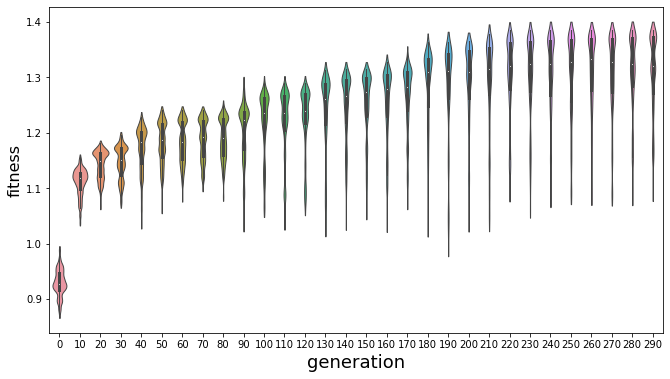

In [12]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))


ax = sns.violinplot(x="generation", y="fitness", data=plot_evolution_scores, bw=.2, cut=1, linewidth=1)

# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)


In [13]:
line_plot_evolution_scores = evolution_scores.groupby("generation")

line_plot_evolution_scores = line_plot_evolution_scores.max()

line_plot_evolution_scores = line_plot_evolution_scores.reset_index()

line_plot_evolution_scores.head()

generation   fitness    use
0           0  0.990471   True
1           1  1.042033  False
2           2  1.048616  False
3           3  1.076388  False
4           4  1.087440  False

<AxesSubplot:xlabel='generation', ylabel='fitness'>

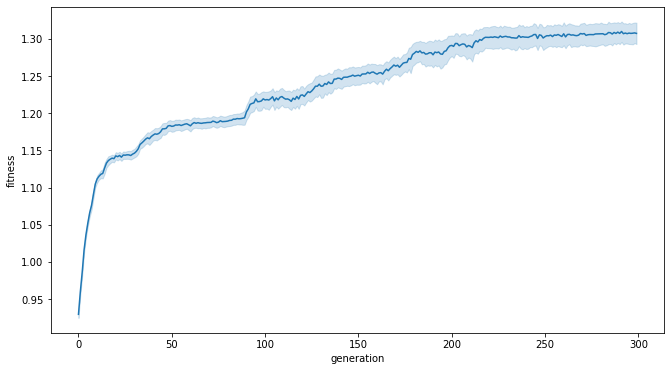

In [14]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=evolution_scores, x="generation", y="fitness")

(array([0.95, 1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

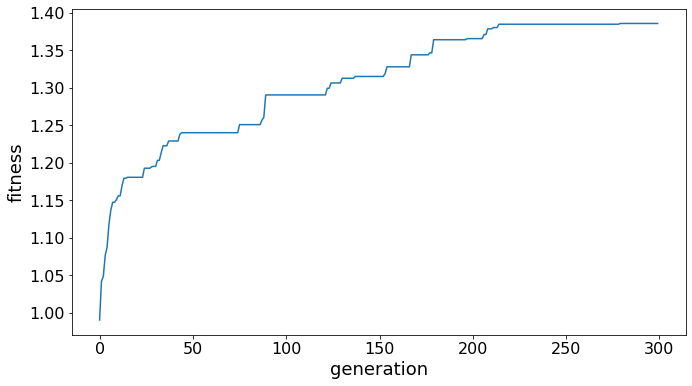

In [18]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=line_plot_evolution_scores, x="generation", y="fitness")
# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [16]:
max_at_0 = evolution_scores[evolution_scores['generation']==0].fitness.max()
max_overall = evolution_scores.fitness.max()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("improvement:",((max_overall-max_at_0)/max_at_0)*100 )

max at 0: 0.9904708500357808
max overall: 1.3857182710458682
improvement: 39.90500285756103


## population scaffold change

In [17]:
best_pop_at_0 = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_1k_100_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_1k_100_300_0randoms_0.csv",encoding='utf-8',names=['file_index'])

In [18]:
best_pop_overall = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_1k_100_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_1k_100_300_0randoms_279.csv",encoding='utf-8',names=['file_index'])

In [19]:
print(len(best_pop_at_0))
print(len(best_pop_overall))

1000
1000


In [20]:
best_pop_at_0 = pd.merge(best_pop_at_0, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_at_0.head()

file_index  query_index                                       query_smiles  \
0    317407.0      2127359                 COCCC(=O)N[C@@H](Cn1ccnc1)c1ccccc1   
1   1223945.0      1382534  CCOC(=O)c1cc(C)sc1NC(=O)[C@H]1[C@@H]2C=C[C@@H]...   
2     13832.0       409285      Cc1c(CN(C)Cc2noc3c2CCCC3)c(=O)n(-c2ccccc2)n1C   
3    900514.0      2835838    O=C(N=CCc1c[nH]c2ccccc12)[C@H]1CCCC[C@H]1C(=O)O   
4   1181531.0      1395155                   CCOC(=O)c1cnc(SC)nc1Nc1ccc(C)cc1   

                                             targets  
0                                        {CHEMBL285}  
1                                       {CHEMBL3577}  
2                            {CHEMBL6032,CHEMBL5896}  
3                                    {CHEMBL1293299}  
4  {CHEMBL1293228,CHEMBL4143,CHEMBL1075138,CHEMBL...

In [21]:
best_pop_overall = pd.merge(best_pop_overall, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_overall.head()

file_index  query_index                                       query_smiles  \
0    858743.0      1988634         COc1ccc(C(=O)Nc2ccnn2C2CCN(C(=O)CN)CC2)cc1   
1      8647.0      2872397              O=C(NCCO)c1ccc(C(=O)C(=O)c2ccccc2)cc1   
2    267053.0      2396491                      NC(=O)c1ccccc1NC(=O)CN1CCOCC1   
3    702292.0       458509  CC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)c3cc(C(F)(F)F...   
4    762023.0      2839878                O=C(NCCCc1ccccn1)c1cccc(Cn2cccn2)c1   

           targets  
0  {CHEMBL1293299}  
1  {CHEMBL1741220}  
2  {CHEMBL1293254}  
3     {CHEMBL6032}  
4     {CHEMBL6152}

In [22]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_at_0,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_at_0, molCol='molecule', MurckoCol='murcko_smiles')

In [23]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_overall,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_overall, molCol='molecule', MurckoCol='murcko_smiles')

In [24]:
max_at_0 = best_pop_at_0['murcko_smiles'].nunique()
max_overall = best_pop_overall['murcko_smiles'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 

max at 0: 910
max overall: 914
% improvement: 0.43956043956043955
 improvement: 4


## cluster representation change

In [25]:
best_pop_at_0 = pd.merge(best_pop_at_0, clusters,  how = 'left', left_on="query_index", right_on="member")
best_pop_overall = pd.merge(best_pop_overall, clusters,  how = 'left', left_on="query_index", right_on="member")

file_index  query_index                                       query_smiles  \
0    317407.0      2127359                 COCCC(=O)N[C@@H](Cn1ccnc1)c1ccccc1   
1   1223945.0      1382534  CCOC(=O)c1cc(C)sc1NC(=O)[C@H]1[C@@H]2C=C[C@@H]...   
2     13832.0       409285      Cc1c(CN(C)Cc2noc3c2CCCC3)c(=O)n(-c2ccccc2)n1C   
3    900514.0      2835838    O=C(N=CCc1c[nH]c2ccccc12)[C@H]1CCCC[C@H]1C(=O)O   
4   1181531.0      1395155                   CCOC(=O)c1cnc(SC)nc1Nc1ccc(C)cc1   

                                             targets  \
0                                        {CHEMBL285}   
1                                       {CHEMBL3577}   
2                            {CHEMBL6032,CHEMBL5896}   
3                                    {CHEMBL1293299}   
4  {CHEMBL1293228,CHEMBL4143,CHEMBL1075138,CHEMBL...   

                                            molecule  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                             murcko_smiles  cluster_id   member  
0                      c1ccc(CCn2ccnc2)cc1     2127359  2127359  
1  O=C(Nc1cccs1)[C@@H]1C[C@H]2C=C[C@@H]1C2     1382534  1382534  
2  O=c1c(CNCc2noc3c2CCCC3)c[nH]n1-c1ccccc1      409285   409285  
3        O=C(N=CCc1c[nH]c2ccccc12)C1CCCCC1     2835838  2835838  
4                      c1ccc(Nc2ccncn2)cc1     1395155  1395155
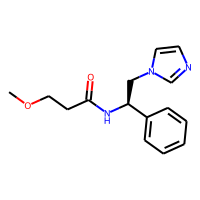
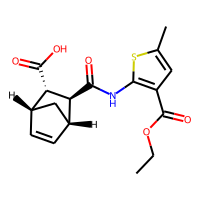
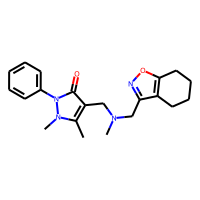
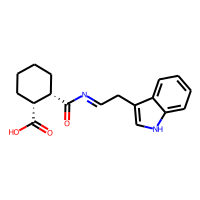
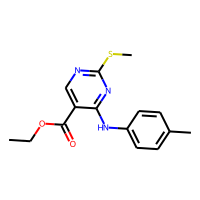

In [26]:
best_pop_at_0.head()

In [27]:
max_at_0 = best_pop_at_0['member'].nunique()
max_overall = best_pop_overall['member'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 1000
max overall: 1000
% improvement: 0.0
 improvement: 0


## target profile changes

#### number of targets

In [28]:
targets_for_0 = pd.DataFrame(best_pop_at_0['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])
print(targets_for_0.shape)

duplicate_at_0 = targets_for_0.shape[0]

targets_for_0.drop_duplicates(inplace = True)

duplicate_at_0 = duplicate_at_0 - targets_for_0.shape[0]

print(targets_for_0.shape)

print(duplicate_at_0)
targets_for_0.head()

(1744, 1)
(369, 1)
1375


targets
0      CHEMBL285
1     CHEMBL3577
2     CHEMBL6032
3     CHEMBL5896
4  CHEMBL1293299

In [29]:
targets_for_best_overall = pd.DataFrame(best_pop_overall['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])

print(targets_for_best_overall.shape)
duplicate_overall = targets_for_best_overall.shape[0]

targets_for_best_overall.drop_duplicates(inplace = True)
duplicate_overall = duplicate_overall - targets_for_best_overall.shape[0]


print(targets_for_best_overall.shape)

print(duplicate_overall)

targets_for_best_overall.head()

(2291, 1)
(512, 1)
1779


targets
0  CHEMBL1293299
1  CHEMBL1741220
2  CHEMBL1293254
3     CHEMBL6032
4     CHEMBL6152

In [30]:
duplicate_overall - duplicate_at_0

404

In [31]:
max_at_0 = targets_for_0['targets'].nunique()
max_overall = targets_for_best_overall['targets'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 369
max overall: 512
% improvement: 38.75338753387534
 improvement: 143


#### number of pfams

In [32]:
targets_for_0 = pd.merge(targets_for_0, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")

targets_for_best_overall = pd.merge(targets_for_best_overall, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")


In [33]:
targets_for_0.head()

targets target_chembl_id   clan     pfam  clan_novelty_score  \
0      CHEMBL285        CHEMBL285    c55  PF03062            0.173514   
1     CHEMBL3577       CHEMBL3577    c10  PF00171            0.939213   
2     CHEMBL6032       CHEMBL6032   c818  PF00856            0.999415   
3     CHEMBL5896       CHEMBL5896  c2021  PF02373            1.000000   
4  CHEMBL1293299    CHEMBL1293299  c1441  PF05965            1.000000   

   pfam_novelty_score  in_actives  in_predicted  
0            0.531489           1             1  
1            0.993938           1             1  
2            0.999330           1             1  
3            0.804554           1             1  
4            1.000000           1             1

In [34]:
print(targets_for_0.shape)
print(targets_for_best_overall.shape)

(387, 8)
(631, 8)


In [35]:


max_at_0 = targets_for_0['pfam'].nunique()
max_overall = targets_for_best_overall['pfam'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 176
max overall: 306
% improvement: 73.86363636363636
 improvement: 130


### change in median novelty score

In [36]:
max_at_0 = targets_for_0['pfam_novelty_score'].median()
max_overall = targets_for_best_overall['pfam_novelty_score'].median()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 0.740440994301759
max overall: 0.757206588881263
% improvement: 2.2642715231230635
 improvement: 0.016765594579503995


# novel7_elitist_pfam_novelty_parallel_1k_500_300_0randoms

## fitness score evolution

In [37]:


evolution_scores = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_1k_500_300_0randoms/result_novel7_elitist_pfam_novelty_parallel_1k_500_300_0randoms.csv",encoding='utf-8')

In [38]:
evolution_scores['use'] = evolution_scores['generation'] % 10 ==0

In [39]:
print(evolution_scores.shape)
evolution_scores.head()

(150000, 3)


fitness  generation   use
0  0.900419           0  True
1  0.909883           0  True
2  0.934615           0  True
3  0.959020           0  True
4  0.968950           0  True

In [40]:
evolution_scores.tail()

fitness  generation    use
149995  1.354832         299  False
149996  1.458082         299  False
149997  1.388255         299  False
149998  1.348728         299  False
149999  1.372906         299  False

In [41]:
plot_evolution_scores = evolution_scores[evolution_scores.use]
plot_evolution_scores.head()

fitness  generation   use
0  0.900419           0  True
1  0.909883           0  True
2  0.934615           0  True
3  0.959020           0  True
4  0.968950           0  True

Text(0, 0.5, 'fitness')

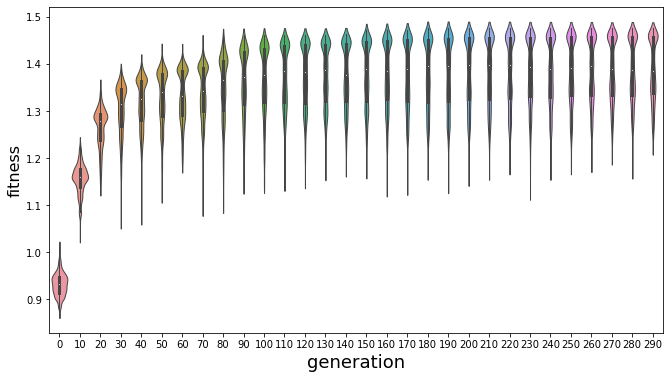

In [42]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))


ax = sns.violinplot(x="generation", y="fitness", data=plot_evolution_scores, bw=.2, cut=1, linewidth=1)

# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)


In [43]:
line_plot_evolution_scores = evolution_scores.groupby("generation")

line_plot_evolution_scores = line_plot_evolution_scores.max()

line_plot_evolution_scores = line_plot_evolution_scores.reset_index()

line_plot_evolution_scores.head()

generation   fitness    use
0           0  1.017651   True
1           1  1.037712  False
2           2  1.057139  False
3           3  1.088354  False
4           4  1.097038  False

<AxesSubplot:xlabel='generation', ylabel='fitness'>

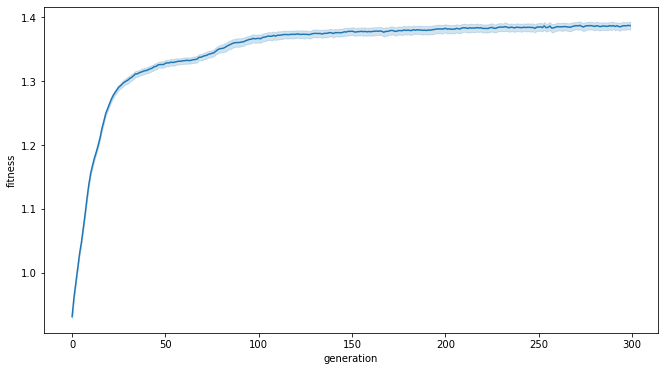

In [44]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=evolution_scores, x="generation", y="fitness")

Text(0, 0.5, 'fitness')

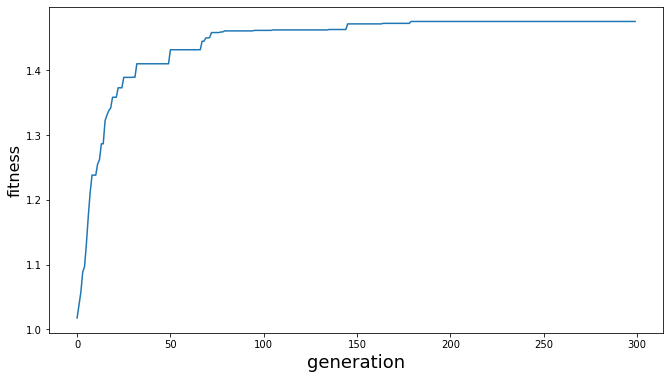

In [45]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=line_plot_evolution_scores, x="generation", y="fitness")
# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)

In [46]:
max_at_0 = evolution_scores[evolution_scores['generation']==0].fitness.max()
max_overall = evolution_scores.fitness.max()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("improvement:",((max_overall-max_at_0)/max_at_0)*100 )

max at 0: 1.0176514385796454
max overall: 1.4752493489342082
improvement: 44.96607512226786


## population scaffold change

In [47]:
best_pop_at_0 = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_1k_500_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_1k_500_300_0randoms_0.csv",encoding='utf-8',names=['file_index'])

In [48]:
best_pop_overall = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_1k_500_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_1k_500_300_0randoms_179.csv",encoding='utf-8',names=['file_index'])

In [49]:
print(len(best_pop_at_0))
print(len(best_pop_overall))

1000
1000


In [50]:
best_pop_at_0 = pd.merge(best_pop_at_0, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_at_0.head()

file_index  query_index                                       query_smiles  \
0   1432998.0      2791769  O=C(N=C1NC(=O)[C@](F)(C(F)(F)F)S1)Nc1ccc(Cl)c(...   
1   1285490.0      1252693  CCn1ncc(C2=NO[C@H](C(=O)Nc3ccc4c(c3)N(S(C)(=O)...   
2    711575.0      1588585              CN1CCN(C(=O)C(=O)Nc2ccc3c(c2)OCO3)CC1   
3     69964.0      2536932          O=C(c1ccc(F)cc1)N1CCN(C[C@@H]2CC=CCC2)CC1   
4     76721.0      1606105       CN1C(=O)c2ccc(NC(=O)c3ccc(Cl)c(Cl)c3)cc2C1=O   

                                            targets  
0  {CHEMBL3577,CHEMBL6032,CHEMBL1293255,CHEMBL2903}  
1                                   {CHEMBL1293232}  
2                                      {CHEMBL5896}  
3             {CHEMBL5896,CHEMBL1293226,CHEMBL6032}  
4       {CHEMBL1293294,CHEMBL1075138,CHEMBL1293277}

In [51]:
best_pop_overall = pd.merge(best_pop_overall, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_overall.head()

file_index  query_index                                       query_smiles  \
0    432267.0      2829176         O=C(NCCc1ccc2c(c1)OCO2)c1ccccc1-c1ncc[nH]1   
1   1278430.0      1428188  CCOC(=O)N1CCN(Cc2nc(=O)c3ccc(C(=O)OC)cc3[nH]2)CC1   
2    749679.0      2812941  O=C(NCc1ccco1)c1ccc2c(c1)C(=O)N(c1ccc(Br)cc1)C2=O   
3    809693.0       175313     Cc1cccc(C(=O)NCC(=O)OCC(=O)NC(=O)Nc2ccccc2F)c1   
4    798518.0      2182322      CO[C@H](C(=O)NC1CCN(Cc2cccc(O)c2)CC1)c1ccccc1   

                         targets  
0  {CHEMBL1293294,CHEMBL1293277}  
1  {CHEMBL1075138,CHEMBL1293299}  
2                   {CHEMBL3577}  
3                {CHEMBL1293303}  
4                    {CHEMBL287}

In [52]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_at_0,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_at_0, molCol='molecule', MurckoCol='murcko_smiles')

In [53]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_overall,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_overall, molCol='molecule', MurckoCol='murcko_smiles')

In [54]:
max_at_0 = best_pop_at_0['murcko_smiles'].nunique()
max_overall = best_pop_overall['murcko_smiles'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 

max at 0: 919
max overall: 921
% improvement: 0.2176278563656148
 improvement: 2


## cluster representation change

In [55]:
best_pop_at_0 = pd.merge(best_pop_at_0, clusters,  how = 'left', left_on="query_index", right_on="member")
best_pop_overall = pd.merge(best_pop_overall, clusters,  how = 'left', left_on="query_index", right_on="member")

file_index  query_index                                       query_smiles  \
0   1432998.0      2791769  O=C(N=C1NC(=O)[C@](F)(C(F)(F)F)S1)Nc1ccc(Cl)c(...   
1   1285490.0      1252693  CCn1ncc(C2=NO[C@H](C(=O)Nc3ccc4c(c3)N(S(C)(=O)...   
2    711575.0      1588585              CN1CCN(C(=O)C(=O)Nc2ccc3c(c2)OCO3)CC1   
3     69964.0      2536932          O=C(c1ccc(F)cc1)N1CCN(C[C@@H]2CC=CCC2)CC1   
4     76721.0      1606105       CN1C(=O)c2ccc(NC(=O)c3ccc(Cl)c(Cl)c3)cc2C1=O   

                                            targets  \
0  {CHEMBL3577,CHEMBL6032,CHEMBL1293255,CHEMBL2903}   
1                                   {CHEMBL1293232}   
2                                      {CHEMBL5896}   
3             {CHEMBL5896,CHEMBL1293226,CHEMBL6032}   
4       {CHEMBL1293294,CHEMBL1075138,CHEMBL1293277}   

                                            molecule  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                    murcko_smiles  cluster_id   member  
0                     O=C1CSC(=NC(=O)Nc2ccccc2)N1     2791769  2791769  
1  O=C(Nc1ccc2c(c1)NCC2)[C@@H]1CC(c2cn[nH]c2)=NO1     1252693  1252693  
2              O=C(Nc1ccc2c(c1)OCO2)C(=O)N1CCNCC1     1588585  1588585  
3          O=C(c1ccccc1)N1CCN(C[C@@H]2CC=CCC2)CC1     2536932  2536932  
4             O=C(Nc1ccc2c(c1)C(=O)NC2=O)c1ccccc1     1606105  1606105
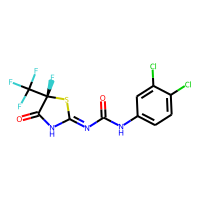
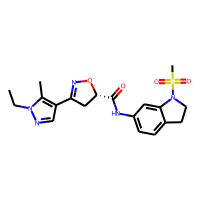
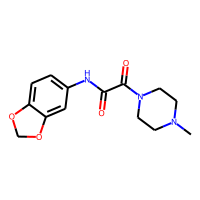
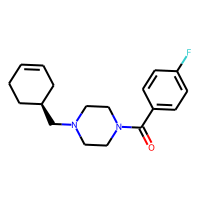
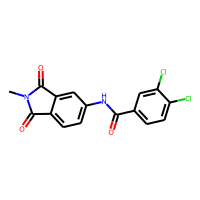

In [56]:
best_pop_at_0.head()

In [57]:
best_pop_at_0['member'].nunique()

1000

In [58]:
best_pop_overall['member'].nunique()

1000

## target profile changes

#### number of targets

In [59]:
targets_for_0 = pd.DataFrame(best_pop_at_0['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])
print(targets_for_0.shape)

duplicate_at_0 = targets_for_0.shape[0]

targets_for_0.drop_duplicates(inplace = True)

duplicate_at_0 = duplicate_at_0 - targets_for_0.shape[0]

print(targets_for_0.shape)

print(duplicate_at_0)
targets_for_0.head()

(1712, 1)
(390, 1)
1322


targets
0     CHEMBL3577
1     CHEMBL6032
2  CHEMBL1293255
3     CHEMBL2903
4  CHEMBL1293232

In [60]:
targets_for_best_overall = pd.DataFrame(best_pop_overall['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])

print(targets_for_best_overall.shape)
duplicate_overall = targets_for_best_overall.shape[0]

targets_for_best_overall.drop_duplicates(inplace = True)
duplicate_overall = duplicate_overall - targets_for_best_overall.shape[0]


print(targets_for_best_overall.shape)

print(duplicate_overall)

targets_for_best_overall.head()

(2385, 1)
(466, 1)
1919


targets
0  CHEMBL1293294
1  CHEMBL1293277
2  CHEMBL1075138
3  CHEMBL1293299
4     CHEMBL3577

In [61]:
duplicate_overall - duplicate_at_0

597

In [62]:
max_at_0 = targets_for_0['targets'].nunique()
max_overall = targets_for_best_overall['targets'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 

max at 0: 390
max overall: 466
% improvement: 19.48717948717949
 improvement: 76


#### number of pfams

In [63]:
targets_for_0 = pd.merge(targets_for_0, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")

targets_for_best_overall = pd.merge(targets_for_best_overall, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")


In [64]:
targets_for_0.head()

targets target_chembl_id   clan     pfam  clan_novelty_score  \
0     CHEMBL3577       CHEMBL3577    c10  PF00171            0.939213   
1     CHEMBL6032       CHEMBL6032   c818  PF00856            0.999415   
2  CHEMBL1293255    CHEMBL1293255  c1964  PF00106            1.000000   
3     CHEMBL2903       CHEMBL2903    c37  PF00305            0.258953   
4  CHEMBL1293232    CHEMBL1293232  c1757  PF06003            0.013047   

   pfam_novelty_score  in_actives  in_predicted  
0            0.993938           1             1  
1            0.999330           1             1  
2            0.634213           1             1  
3            0.323928           1             1  
4            0.013047           1             1

In [65]:
print(targets_for_0.shape)
print(targets_for_best_overall.shape)

(409, 8)
(575, 8)


In [66]:


max_at_0 = targets_for_0['pfam'].nunique()
max_overall = targets_for_best_overall['pfam'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 

max at 0: 198
max overall: 301
% improvement: 52.02020202020202
 improvement: 103


### change in median novelty score

In [67]:
max_at_0 = targets_for_0['pfam_novelty_score'].median()
max_overall = targets_for_best_overall['pfam_novelty_score'].median()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 0.7198050817960321
max overall: 0.757206588881263
% improvement: 5.196060437904665
 improvement: 0.037401507085230934


# novel7_elitist_pfam_novelty_parallel_1k_1000_300_0randoms

## fitness score evolution

In [7]:


evolution_scores = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_1k_1000_300_0randoms/result_novel7_elitist_pfam_novelty_parallel_1k_1000_300_0randoms.csv",encoding='utf-8')

In [8]:
evolution_scores['use'] = evolution_scores['generation'] % 10 ==0

In [9]:
print(evolution_scores.shape)
evolution_scores.head()

(300000, 3)


fitness  generation   use
0  0.916309           0  True
1  0.926341           0  True
2  0.927190           0  True
3  0.931692           0  True
4  0.928449           0  True

In [10]:
evolution_scores.tail()

fitness  generation    use
299995  1.549945         299  False
299996  1.515862         299  False
299997  1.654649         299  False
299998  1.605072         299  False
299999  1.497768         299  False

In [11]:
plot_evolution_scores = evolution_scores[evolution_scores.use]
plot_evolution_scores.head()

fitness  generation   use
0  0.916309           0  True
1  0.926341           0  True
2  0.927190           0  True
3  0.931692           0  True
4  0.928449           0  True

Text(0, 0.5, 'fitness')

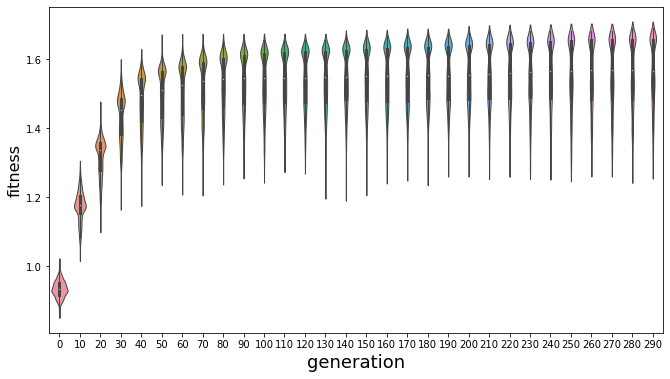

In [12]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))


ax = sns.violinplot(x="generation", y="fitness", data=plot_evolution_scores, bw=.2, cut=1, linewidth=1)

# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)


In [13]:
line_plot_evolution_scores = evolution_scores.groupby("generation")

line_plot_evolution_scores = line_plot_evolution_scores.max()

line_plot_evolution_scores = line_plot_evolution_scores.reset_index()

line_plot_evolution_scores.head()

generation   fitness    use
0           0  1.017570   True
1           1  1.044193  False
2           2  1.062889  False
3           3  1.082210  False
4           4  1.122099  False

<AxesSubplot:xlabel='generation', ylabel='fitness'>

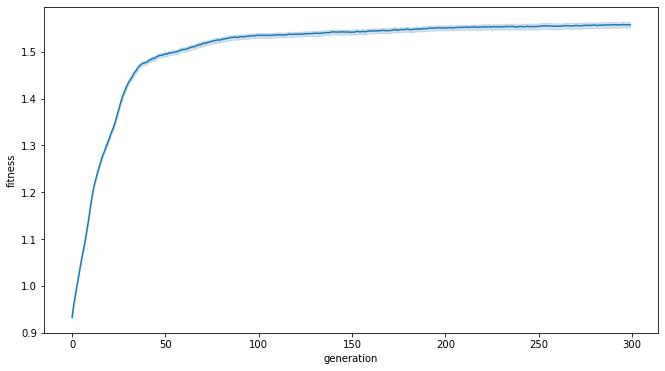

In [14]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=evolution_scores, x="generation", y="fitness")

Text(0, 0.5, 'fitness')

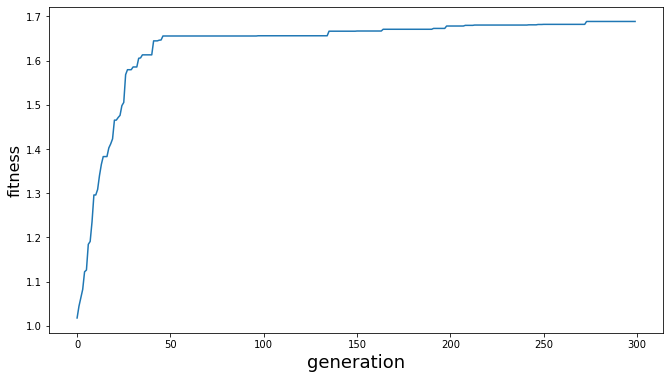

In [15]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=line_plot_evolution_scores, x="generation", y="fitness")
# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)

In [16]:
max_at_0 = evolution_scores[evolution_scores['generation']==0].fitness.max()
max_overall = evolution_scores.fitness.max()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("improvement:",((max_overall-max_at_0)/max_at_0)*100 )

max at 0: 1.017570105131704
max overall: 1.6887527391655794
improvement: 65.9593506775638


## population scaffold change

In [17]:
best_pop_at_0 = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_1k_1000_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_1k_1000_300_0randoms_0.csv",encoding='utf-8',names=['file_index'])

In [18]:
best_pop_overall = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_1k_1000_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_1k_1000_300_0randoms_273.csv",encoding='utf-8',names=['file_index'])

In [19]:
print(len(best_pop_at_0))
print(len(best_pop_overall))

1000
1000


In [20]:
best_pop_at_0 = pd.merge(best_pop_at_0, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_at_0.head()

file_index  query_index                                       query_smiles  \
0    211466.0       578784              Cc1nc(NC(=O)N[C@@H](C)c2cccnc2)ccc1Br   
1    716513.0      2165916  COCC(=O)/N=C1/S[C@@H]2CS(=O)(=O)C[C@@H]2N1c1c(...   
2    582708.0      1840505         COc1ccccc1-c1nc2sc(=Cc3ccc(C)cc3)c(=O)n2n1   
3    619977.0      2517610        O=C(C1CCCC1)N1CCC[C@@H]1c1ccnc(Nc2ccccn2)n1   
4    659080.0       869586    CC(C)CNC(=O)C(=O)NC[C@H](c1cccs1)N1CCc2ccccc2C1   

                                    targets  
0  {CHEMBL1293294,CHEMBL1293277,CHEMBL5567}  
1                           {CHEMBL1293238}  
2  {CHEMBL6032,CHEMBL1293303,CHEMBL1293227}  
3                              {CHEMBL3227}  
4                              {CHEMBL1784}

In [21]:
best_pop_overall = pd.merge(best_pop_overall, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_overall.head()

file_index  query_index                                   query_smiles  \
0    281406.0      2845499             O=C(NCCCn1ccnc1)c1ccc(Cn2ccnc2)cc1   
1    293444.0       243050           Cc1ccc(C(=O)/N=c2\nc3cc(C)ccn3s2)cc1   
2    579801.0      2316718         Fc1ccc(-c2nn3c(-c4ccsc4)nnc3s2)c(F)c1F   
3     93700.0      1833513  COc1ccc(-c2nnn(CC(=O)N[C@H](C)c3ccccc3)n2)cc1   
4    741925.0       482146       Cc1cnc(C(=O)Nc2ccc(-c3cn4ccsc4n3)cc2)cn1   

                                             targets  
0                                       {CHEMBL4028}  
1  {CHEMBL1293277,CHEMBL1293232,CHEMBL5149,CHEMBL...  
2                            {CHEMBL5695,CHEMBL1914}  
3                      {CHEMBL1293254,CHEMBL1075189}  
4  {CHEMBL1293294,CHEMBL1293277,CHEMBL1741209,CHE...

In [22]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_at_0,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_at_0, molCol='molecule', MurckoCol='murcko_smiles')

In [23]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_overall,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_overall, molCol='molecule', MurckoCol='murcko_smiles')

In [24]:
max_at_0 = best_pop_at_0['murcko_smiles'].nunique()
max_overall = best_pop_overall['murcko_smiles'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 

max at 0: 922
max overall: 908
% improvement: -1.5184381778741864
 improvement: -14


## cluster representation change

In [25]:
best_pop_at_0 = pd.merge(best_pop_at_0, clusters,  how = 'left', left_on="query_index", right_on="member")
best_pop_overall = pd.merge(best_pop_overall, clusters,  how = 'left', left_on="query_index", right_on="member")

file_index  query_index                                       query_smiles  \
0    211466.0       578784              Cc1nc(NC(=O)N[C@@H](C)c2cccnc2)ccc1Br   
1    716513.0      2165916  COCC(=O)/N=C1/S[C@@H]2CS(=O)(=O)C[C@@H]2N1c1c(...   
2    582708.0      1840505         COc1ccccc1-c1nc2sc(=Cc3ccc(C)cc3)c(=O)n2n1   
3    619977.0      2517610        O=C(C1CCCC1)N1CCC[C@@H]1c1ccnc(Nc2ccccn2)n1   
4    659080.0       869586    CC(C)CNC(=O)C(=O)NC[C@H](c1cccs1)N1CCc2ccccc2C1   

                                    targets  \
0  {CHEMBL1293294,CHEMBL1293277,CHEMBL5567}   
1                           {CHEMBL1293238}   
2  {CHEMBL6032,CHEMBL1293303,CHEMBL1293227}   
3                              {CHEMBL3227}   
4                              {CHEMBL1784}   

                                            molecule  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                 murcko_smiles  cluster_id   member  
0                     O=C(NCc1cccnc1)Nc1ccccn1      578784   578784  
1     N=C1S[C@@H]2CS(=O)(=O)C[C@@H]2N1c1ccccc1     2165916  2165916  
2        O=c1c(=Cc2ccccc2)sc2nc(-c3ccccc3)nn12     1840505  1840505  
3  O=C(C1CCCC1)N1CCC[C@@H]1c1ccnc(Nc2ccccn2)n1     2517610  2517610  
4                     c1csc(CN2CCc3ccccc3C2)c1      869586   869586
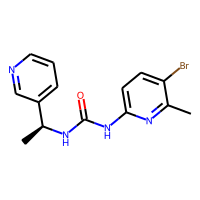
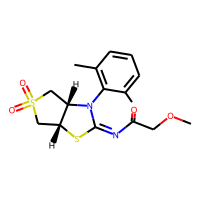
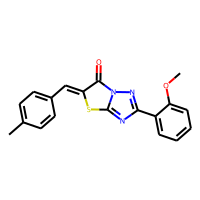
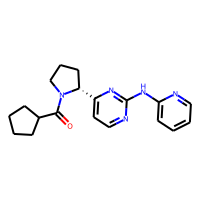
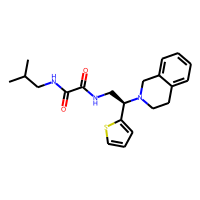

In [26]:
best_pop_at_0.head()

In [27]:
best_pop_at_0['member'].nunique()

1000

In [28]:
best_pop_overall['member'].nunique()

1000

## target profile changes

#### number of targets

In [29]:
targets_for_0 = pd.DataFrame(best_pop_at_0['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])
print(targets_for_0.shape)

duplicate_at_0 = targets_for_0.shape[0]

targets_for_0.drop_duplicates(inplace = True)

duplicate_at_0 = duplicate_at_0 - targets_for_0.shape[0]

print(targets_for_0.shape)

print(duplicate_at_0)
targets_for_0.head()


(1744, 1)
(432, 1)
1312


targets
0  CHEMBL1293294
1  CHEMBL1293277
2     CHEMBL5567
3  CHEMBL1293238
4     CHEMBL6032

In [39]:
targets_for_best_overall = pd.DataFrame(best_pop_overall['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])



In [52]:
repeated_targets_final = targets_for_best_overall[['targets']].groupby(['targets'])['targets'].count().reset_index(name='count').sort_values(['count'], ascending=False)

In [54]:
repeated_targets_final

targets  count
46   CHEMBL1293294    117
42   CHEMBL1293277    110
400     CHEMBL5567     96
4    CHEMBL1075138     96
49   CHEMBL1293303     92
422     CHEMBL6032     66
20   CHEMBL1293232     65
19   CHEMBL1293231     64
293     CHEMBL3577     62
12   CHEMBL1287622     50
416     CHEMBL5896     47
73   CHEMBL1741209     45
43   CHEMBL1293278     44
24   CHEMBL1293238     39
425     CHEMBL6110     35
421     CHEMBL5990     33
248     CHEMBL3024     32
82      CHEMBL1784     31
195     CHEMBL2392     29
78   CHEMBL1741220     25
297     CHEMBL3622     25
48   CHEMBL1293299     22
398     CHEMBL5542     22
33   CHEMBL1293254     21
3    CHEMBL1075094     21
282     CHEMBL3397     20
278     CHEMBL3356     20
402     CHEMBL5619     20
16   CHEMBL1293227     19
389     CHEMBL5391     19
..             ...    ...
191     CHEMBL2366      1
186      CHEMBL235      1
185     CHEMBL2334      1
184  CHEMBL2331053      1
182      CHEMBL233      1
230     CHEMBL2775      1
179     CHEMBL2284      1
178      CHEMBL228      1
177     CHEMBL2276      1
176      CHEMBL227      1
173     CHEMBL2231      1
172      CHEMBL222      1
201  CHEMBL2429708      1
202      CHEMBL243      1
203     CHEMBL2431      1
204     CHEMBL2439      1
206      CHEMBL245      1
207     CHEMBL2457      1
208      CHEMBL248      1
209     CHEMBL2487      1
210      CHEMBL249      1
213     CHEMBL2536      1
216     CHEMBL2590      1
222      CHEMBL264      1
224     CHEMBL2730      1
225     CHEMBL2734      1
226     CHEMBL2736      1
227     CHEMBL2738      1
228      CHEMBL274      1
434     CHEMBL6185      1

[435 rows x 2 columns]

array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

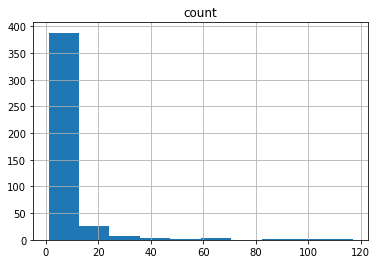

In [53]:
repeated_targets_final.hist(10)

In [51]:
targets_for_best_overall[targets_for_best_overall.targets == 'CHEMBL3987582']

targets
148  CHEMBL3987582
555  CHEMBL3987582

In [30]:
targets_for_best_overall = pd.DataFrame(best_pop_overall['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])

print(targets_for_best_overall.shape)
duplicate_overall = targets_for_best_overall.shape[0]

targets_for_best_overall.drop_duplicates(inplace = True)
duplicate_overall = duplicate_overall - targets_for_best_overall.shape[0]


print(targets_for_best_overall.shape)

print(duplicate_overall)


targets_for_best_overall.head()

(2567, 1)
(435, 1)
2132


targets
0     CHEMBL4028
1  CHEMBL1293277
2  CHEMBL1293232
3     CHEMBL5149
4  CHEMBL1287622

In [31]:
duplicate_overall - duplicate_at_0

820

In [32]:
max_at_0 = targets_for_0['targets'].nunique()
max_overall = targets_for_best_overall['targets'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 

max at 0: 432
max overall: 435
% improvement: 0.6944444444444444
 improvement: 3


In [36]:
set(targets_for_best_overall['targets'].unique()) - set(targets_for_0['targets'].unique())

{'CHEMBL1075040',
 'CHEMBL1075043',
 'CHEMBL1075051',
 'CHEMBL1250413',
 'CHEMBL1255150',
 'CHEMBL1287620',
 'CHEMBL1293222',
 'CHEMBL1293229',
 'CHEMBL1293239',
 'CHEMBL1293245',
 'CHEMBL1293246',
 'CHEMBL1293256',
 'CHEMBL1293257',
 'CHEMBL1293266',
 'CHEMBL1293275',
 'CHEMBL1293286',
 'CHEMBL1293291',
 'CHEMBL1293297',
 'CHEMBL1293308',
 'CHEMBL1293311',
 'CHEMBL1687683',
 'CHEMBL1741163',
 'CHEMBL1741172',
 'CHEMBL1741185',
 'CHEMBL1741195',
 'CHEMBL1795086',
 'CHEMBL1795087',
 'CHEMBL1795089',
 'CHEMBL1821',
 'CHEMBL1825',
 'CHEMBL1867',
 'CHEMBL1878',
 'CHEMBL1902',
 'CHEMBL1907589',
 'CHEMBL1907594',
 'CHEMBL1907600',
 'CHEMBL1907605',
 'CHEMBL1908389',
 'CHEMBL1909484',
 'CHEMBL1940',
 'CHEMBL1961783',
 'CHEMBL1961790',
 'CHEMBL1966',
 'CHEMBL1974',
 'CHEMBL1977',
 'CHEMBL1993',
 'CHEMBL2000',
 'CHEMBL2007628',
 'CHEMBL2007629',
 'CHEMBL2029197',
 'CHEMBL203',
 'CHEMBL2034805',
 'CHEMBL2035',
 'CHEMBL2061',
 'CHEMBL2072',
 'CHEMBL2085',
 'CHEMBL2094108',
 'CHEMBL2094135',
 'CHE

#### number of pfams

In [94]:
targets_for_0 = pd.merge(targets_for_0, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")

targets_for_best_overall = pd.merge(targets_for_best_overall, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")


In [95]:
targets_for_0.head()

targets target_chembl_id   clan     pfam  clan_novelty_score  \
0  CHEMBL1293294    CHEMBL1293294  c1464  PF00071            1.000000   
1  CHEMBL1293277    CHEMBL1293277  c3016  PF16414            1.000000   
2     CHEMBL5567       CHEMBL5567   c249  PF00501            0.926807   
3  CHEMBL1293238    CHEMBL1293238   c780  PF00459            0.000671   
4     CHEMBL6032       CHEMBL6032   c818  PF00856            0.999415   

   pfam_novelty_score  in_actives  in_predicted  
0            0.995925           1             1  
1            0.995817           1             1  
2            0.917624           1             1  
3            0.000671           1             1  
4            0.999330           1             1

In [96]:
print(targets_for_0.shape)
print(targets_for_best_overall.shape)

(447, 8)
(543, 8)


In [97]:


max_at_0 = targets_for_0['pfam'].nunique()
max_overall = targets_for_best_overall['pfam'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 

max at 0: 210
max overall: 321
% improvement: 52.85714285714286
 improvement: 111


### change in median novelty score

In [98]:
max_at_0 = targets_for_0['pfam_novelty_score'].median()
max_overall = targets_for_best_overall['pfam_novelty_score'].median()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 0.691573370651739
max overall: 0.7788518299881941
% improvement: 12.620274730098979
 improvement: 0.08727845933645517
